# End-to-end Multi-Class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow.

## 1. Problem

Identify the breed of a dog given an image of a dog.

## 2. Data 

The data is from Kaggle's dog breed identification competition:
https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation
The evaluation is prediction probabilities of each dog breed of each test image (softmax)

## 4. Features

* The data consists of images (unstructured data) with 120 breeds of dogs
* There are 10,000+ images in the training set, 10,000+ images in the test set

In [2]:
# Unzip the uploaded data into Google Drive
#!unzip "drive/MyDrive/Data/dog-breed-identification.zip" -d "drive/MyDrive/Data/"

### Get our workspace ready

In [3]:
# Import tools 
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__, hub.__version__)

2.9.2 0.12.0


## Getting our data ready (turning into Tensors)

Turning our images into Tensors (numerical representation)

Let's start by accessing our data and checking out the labels.

In [4]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [5]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


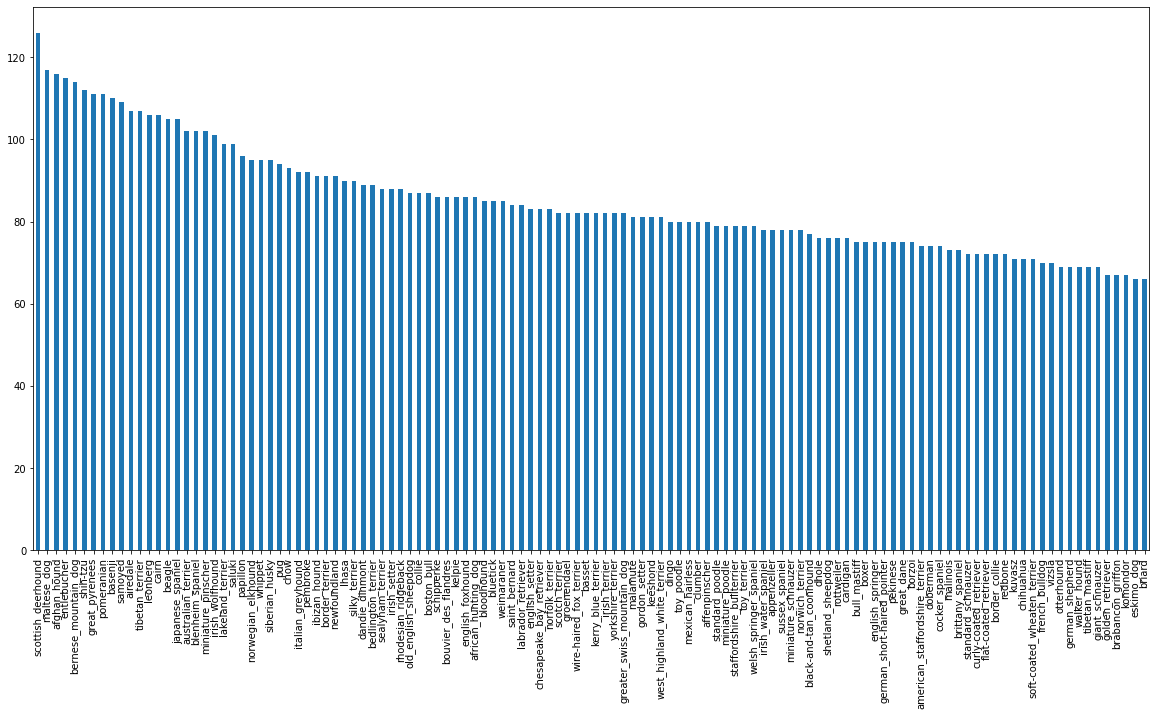

In [6]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [7]:
labels_csv["breed"].value_counts().median()

82.0

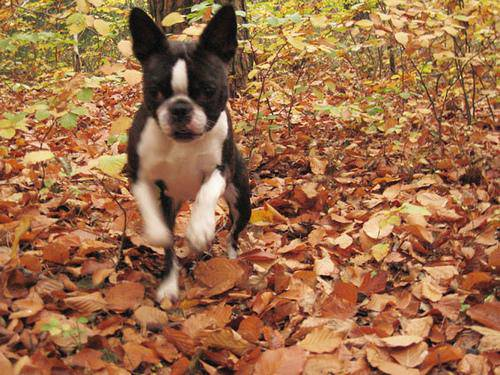

In [8]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Data/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames

In [9]:
# Create pathnames for image ID
filenames = ["drive/MyDrive/Data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 
filenames[:10]

['drive/MyDrive/Data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Data/train/")) == len(filenames):
  print("matched")

matched


rhodesian_ridgeback


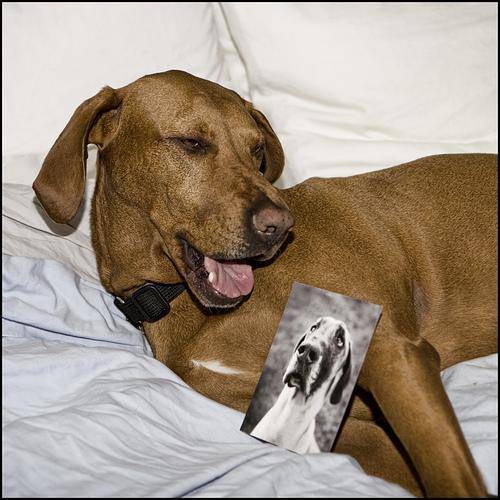

In [11]:
print(labels_csv["breed"][100])
Image(filenames[100])

In [12]:
# Prepare labels
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [13]:
len(labels)

10222

In [14]:
# Check whether we have missing labels or filenames
len(filenames)

10222

In [15]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [16]:
# Turn labels into boolean array
boolean_labels = [label == unique_breeds for label in labels]

### Create validation set

In [17]:
# Setup X & y 
X = filenames
y = boolean_labels

We will start with 1000 images and increase as needed

In [18]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000}

In [19]:
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

In [20]:
X_train[0], y_train[0]

('drive/MyDrive/Data/train/00bee065dcec471f26394855c5c2f3de.jpg',
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        Fal

## Preprocessing Images (turning images into Tensors)

Create a function to:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image`
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [21]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 color channels RGB
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

## Turning our data into batches

We need data in the form of Tensor tuples: `(image, label)`

In [22]:
# Create a function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  preprocesses the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [23]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y)
  Shuffles the data if it's training data but doesn't shuffle if it's validation data
  Also accepts test data as input (no lbels)
  """
  # If the data is a test dataset, we don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  # If the data is validation dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # both filepaths and labels
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  
  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor is faster than shuffling image
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples after turning the image path into a preprocessed image
    data = data.map(get_image_label)

    # Turn the training data in batches 
    data_batch = data.batch(batch_size)
    return data_batch

In [24]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [25]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches



In [26]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  for i in range(25):
    # Create subplots (5 rows, 5 cols)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

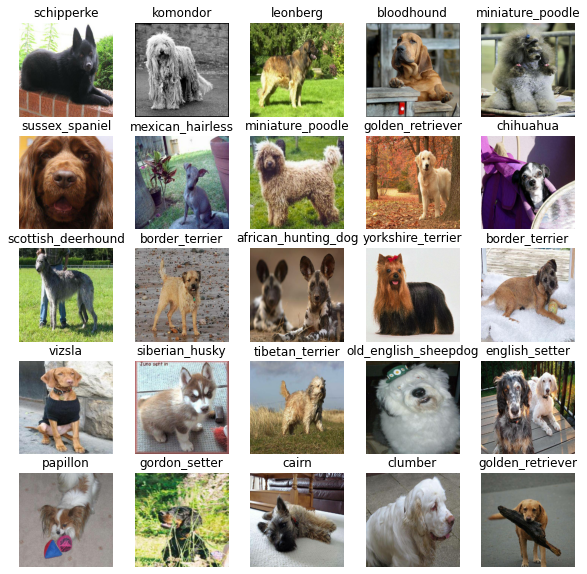

In [27]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

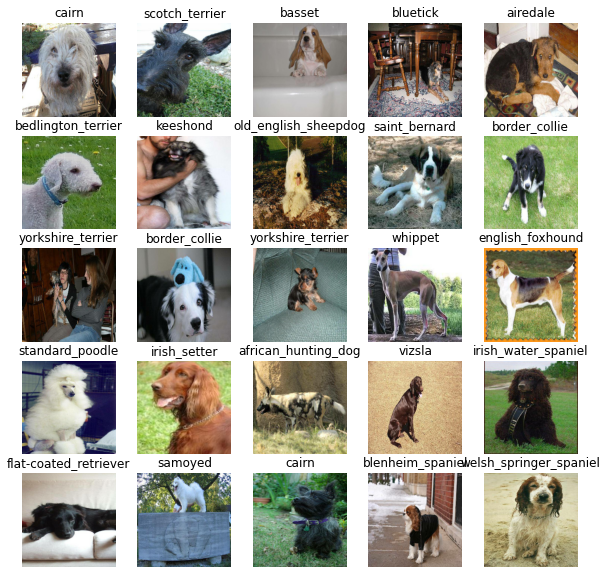

In [28]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model
Define:
* The input shape (our images shape)
* The output shape (image labels)
* The URL of the model from TensorFlow Hub

In [29]:
# Setup input shape to the model
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Setup output shape of our model
output_shape = len(unique_breeds)

# Setup model URL from TensorFlow Hub
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [30]:
# Create a function which builds a Keras model
def create_model(input_shape=input_shape, output_shape=output_shape, model_url=model_url):
  # Setup layers
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url),
      tf.keras.layers.Dense(output_shape, activation="softmax")      
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(input_shape)

  return model

In [31]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

1. TensorBoard to check progress
2. Early stopping to prevent overfitting

### TensorBoard callback
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback to save logs to a directory and pass it to our model's `fit` function
3. Visualize model training logs with `%tensorboard`


In [32]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [33]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving

In [34]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

## Training a model (on subset of data)

In [35]:
epochs = 100 #@param {type:"slider", min:10, max:100, step:10}

In [36]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(train_data,
            epochs = epochs,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  return model

In [37]:
# Fit the model to the data
model = train_model()

Epoch 1/100
25/25 [==============================] - 168s 6s/step - loss: 4.6288 - accuracy: 0.0875 - val_loss: 3.4077 - val_accuracy: 0.2350
Epoch 2/100
25/25 [==============================] - 4s 154ms/step - loss: 1.6927 - accuracy: 0.6600 - val_loss: 2.0714 - val_accuracy: 0.5550
Epoch 3/100
25/25 [==============================] - 3s 132ms/step - loss: 0.5995 - accuracy: 0.9225 - val_loss: 1.6061 - val_accuracy: 0.6250
Epoch 4/100
25/25 [==============================] - 3s 135ms/step - loss: 0.2633 - accuracy: 0.9850 - val_loss: 1.4376 - val_accuracy: 0.6600
Epoch 5/100
25/25 [==============================] - 4s 153ms/step - loss: 0.1528 - accuracy: 0.9987 - val_loss: 1.3652 - val_accuracy: 0.6600
Epoch 6/100
25/25 [==============================] - 4s 153ms/step - loss: 0.1025 - accuracy: 0.9987 - val_loss: 1.3221 - val_accuracy: 0.6700
Epoch 7/100
25/25 [==============================] - 3s 131ms/step - loss: 0.0768 - accuracy: 1.0000 - val_loss: 1.2893 - val_accuracy: 0.6700


### Checking the TensorBoard logs

The TensorBoard will access the logs directory we created earlier and visualize its content

In [81]:
#%tensorboard --logdir drive/MyDrive/Data/logs

## Making and evaluating a predictions using a trained model

In [39]:
# Make predictions 
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 10s 102ms/step


array([[2.0035135e-03, 4.7863802e-04, 1.6696599e-03, ..., 2.0153967e-04,
        3.9859897e-05, 5.3439946e-03],
       [2.0496806e-03, 9.3945261e-04, 8.5909888e-03, ..., 3.4383961e-04,
        1.6165958e-03, 4.4568791e-04],
       [7.7005934e-06, 3.9585630e-05, 2.9488412e-05, ..., 2.9774883e-04,
        1.2844135e-05, 3.6803717e-04],
       ...,
       [1.3550545e-06, 1.5625737e-05, 3.4198336e-05, ..., 6.8938102e-06,
        2.0705647e-04, 1.6477577e-04],
       [3.0639663e-03, 3.3283405e-04, 5.8824215e-05, ..., 6.6501269e-04,
        4.4134973e-05, 1.0283330e-02],
       [7.7924167e-04, 1.5472069e-05, 6.6922960e-04, ..., 9.8191819e-04,
        5.9521379e-04, 2.5710952e-04]], dtype=float32)

In [40]:
# First prediction
index = 0
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[2.00351351e-03 4.78638016e-04 1.66965986e-03 6.62631792e-05
 4.67425969e-04 1.76730373e-05 9.05143004e-03 6.00382882e-05
 9.59441240e-04 5.23723720e-04 5.39099507e-04 2.34266845e-04
 1.03481936e-04 8.38898559e-05 9.73804621e-04 2.90484226e-04
 5.26510048e-05 1.20845310e-01 7.22810046e-06 1.93296699e-04
 3.96609626e-04 2.77671672e-04 3.43972133e-05 4.94456908e-04
 1.62022319e-04 2.47097661e-04 2.34719485e-01 8.71968005e-05
 1.09379413e-03 3.81681399e-04 8.45464456e-05 1.68075750e-03
 6.53695781e-04 1.54411209e-05 6.28294016e-04 8.53227973e-02
 1.63508430e-05 6.47619134e-04 4.52816894e-05 9.49228706e-05
 1.03458157e-03 1.30340150e-05 3.01818636e-05 3.15554207e-04
 2.48137876e-05 3.77777731e-04 2.26996617e-05 3.18457081e-04
 6.47468143e-04 7.32729022e-05 3.25008223e-05 4.78152324e-05
 2.31651752e-03 8.24320523e-05 1.29816530e-04 1.04356637e-04
 1.04400876e-03 1.82780542e-03 4.71217412e-04 7.94971511e-02
 1.23296480e-03 4.51678716e-05 4.07601154e-04 2.07630892e-05
 3.88241780e-04 4.085664

In [41]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

Since our validation data is still in a batch dataset, we will have to unbatch it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [42]:
# Create a function to unbatch a batch dataset
def unbatch_data(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels
  """
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels
  
# Unbatch the validation data
val_images, val_labels = unbatch_data(val_data)

In [43]:
images_ = []
labels_ = []

for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visual

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and integers.
* Convert the prediction probabilities to a predicted label
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot

In [44]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                  np.max(pred_prob)*100,
                                  true_label),
                                  color=color)

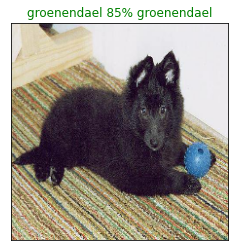

In [45]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 prediction_probabilities

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer 
* Find the prediction using the `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities ValuesView
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green

In [46]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

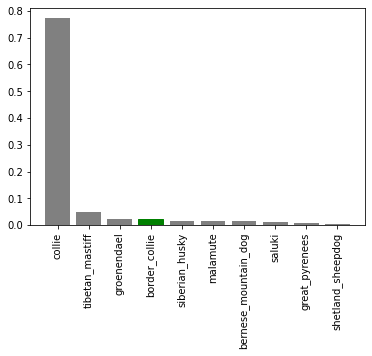

In [47]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some functions to help us visualize our predictions and evaluate our models, let's check out

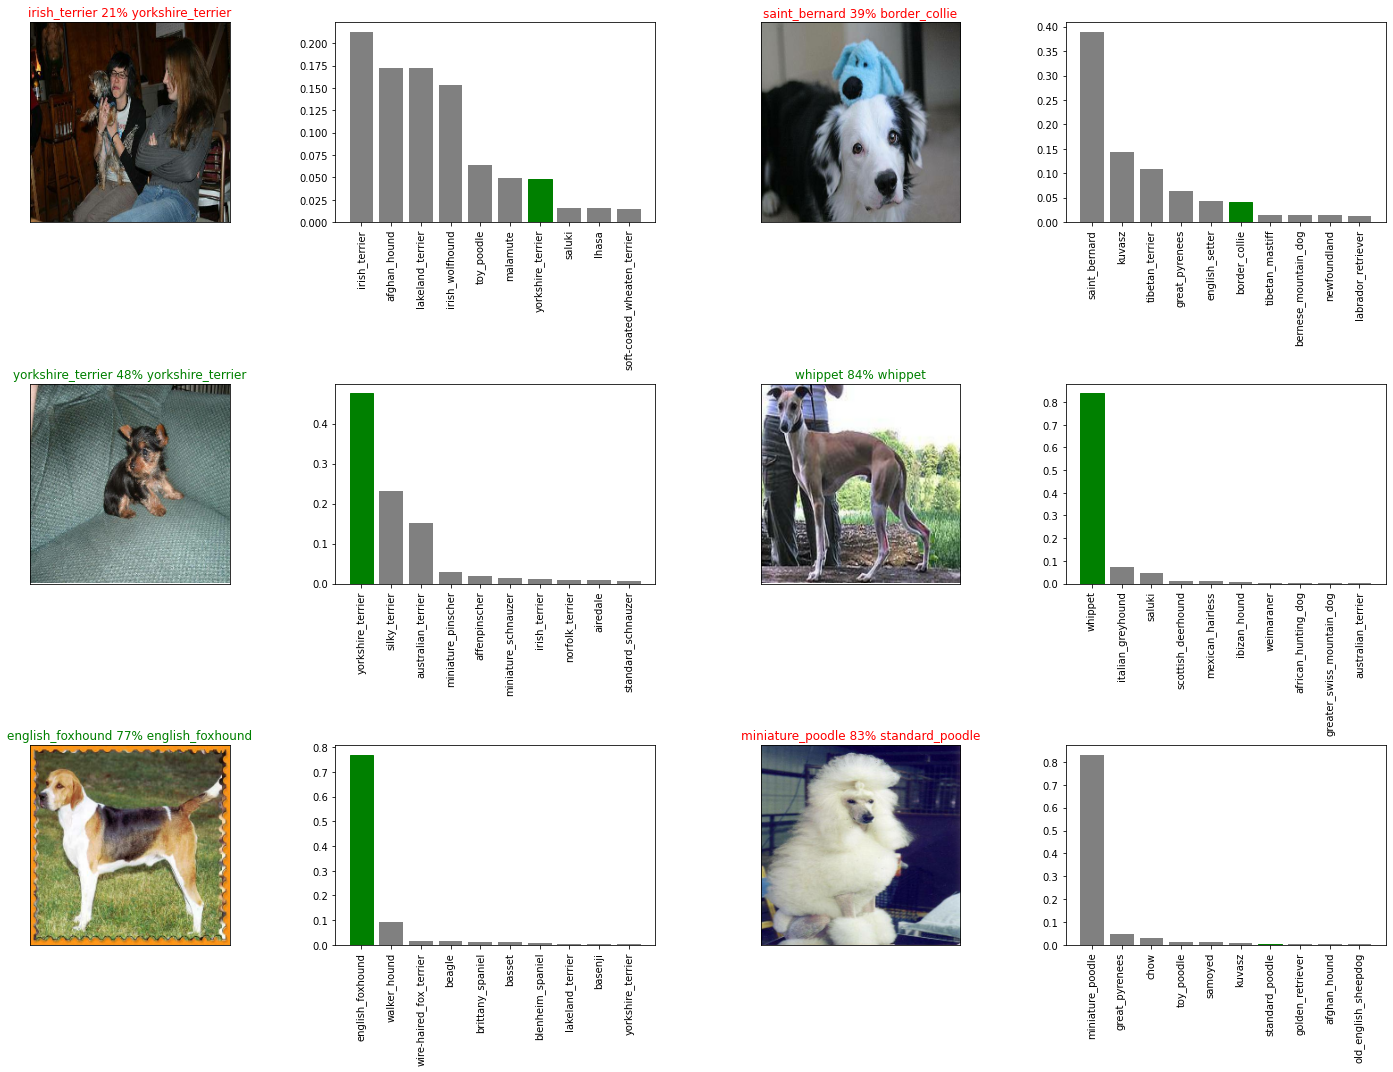

In [48]:
# Let's check out a few predictions and their different values
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
            labels=val_labels,
            n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

##Saving and reloading a trained model

In [49]:
# Create a function to save a model
def save_model(model, suffix = None):
  """
  Saves a given model in a model directory and appends a suffix(string)
  """
  modeldir = os.path.join("drive/MyDrive/Data/model",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" +  suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [50]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
 
  return model  

Now we've got functions to save and load a trained model, let's make sure they work!

In [51]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Data/model/20221028-21341666992881-1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Data/model/20221028-21341666992881-1000-images-mobilenetv2-Adam.h5'

In [52]:
# Load atrained model
loaded_1000_image_model = load_model("drive/MyDrive/Data/model/20221028-19531666986793-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Data/model/20221028-19531666986793-1000-images-mobilenetv2-Adam.h5


In [53]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 84ms/step - loss: 1.1978 - accuracy: 0.6850


[1.1978214979171753, 0.6850000023841858]

In [54]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 91ms/step - loss: 1.1842 - accuracy: 0.6800


[1.1842069625854492, 0.6800000071525574]

## Training on the full data

In [55]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)

Creating training data batches...


In [56]:
full_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [57]:
# Create a model for full model
full_model = create_model()

In [58]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [60]:
# Fit the full model to the full data
full_model.fit(full_data,
               epochs=epochs,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 39s 110ms/step - loss: 1.3455 - accuracy: 0.6709
Epoch 2/100
320/320 [==============================] - 36s 113ms/step - loss: 0.3969 - accuracy: 0.8847
Epoch 3/100
320/320 [==============================] - 40s 125ms/step - loss: 0.2361 - accuracy: 0.9358
Epoch 4/100
320/320 [==============================] - 37s 114ms/step - loss: 0.1523 - accuracy: 0.9655
Epoch 5/100
320/320 [==============================] - 38s 118ms/step - loss: 0.1073 - accuracy: 0.9770
Epoch 6/100
320/320 [==============================] - 38s 119ms/step - loss: 0.0772 - accuracy: 0.9867
Epoch 7/100
320/320 [==============================] - 40s 124ms/step - loss: 0.0580 - accuracy: 0.9920
Epoch 8/100
320/320 [==============================] - 51s 159ms/step - loss: 0.0470 - accuracy: 0.9943
Epoch 9/100
320/320 [==============================] - 39s 122ms/step - loss: 0.0373 - accuracy: 0.9960
Epoch 10/100
320/320 [==============================] - 40s 126m

In [61]:
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Data/model/20221028-21581666994300-1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Data/model/20221028-21581666994300-1000-images-mobilenetv2-Adam.h5'

In [64]:
# Load in the full model
loaded_full_model = load_model("drive/MyDrive/Data/model/20221028-21581666994300-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Data/model/20221028-21581666994300-1000-images-mobilenetv2-Adam.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

We'll use `create_data_batch()` to convert filenames into Tensor batches

To make predictions on the test data, we will:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since test data doesn't have labels)
* Make a predictions array by passing the test batches to the `predict()` method called on our model

In [65]:
# Load test image filenames
test_path = "drive/MyDrive/Data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
len(test_filenames)

10357

In [66]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [68]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [70]:
from tensorflow.python.ops.gen_data_flow_ops import TensorArraySplitV2
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 3624s 11s/step


In [71]:
# Save predictions (NumPy array) to csv file
np.savetxt("drive/MyDrive/Data/preds_array.csv", test_predictions, delimiter=",")

In [72]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/MyDrive/Data/preds_array.csv", delimiter=",")

## Preparing test dataset predictions for Kaggle

We need a DataFrame with an ID and a column for each different dog breed

To get the data in this format, we will:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed
* Add data to the ID column by extracting the test image ID's from the filepaths
* Add data (the prediction probabilities) to each of the dog breed columns
* Export the DataFrame as a CSV to submit it to Kaggle

In [73]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [74]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e1a777d181483b0982732fa4128df7f8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e55534e27f92b4c8177ed2beb1cbba7b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e138d8e5745db1213cc08131e7420c7a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e6920cc0fd2e3099506d23761d9682e1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e4a8dfc6e219b20a0cbced41eaf6a435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e1a777d181483b0982732fa4128df7f8,0.001545,0.000006,0.000280,0.000312,0.001058,0.000116,0.012805,0.001251,0.002116,...,0.000261,0.000473,0.000081,0.000212,0.000040,0.000322,0.004159,0.000161,0.000124,0.011814
1,e55534e27f92b4c8177ed2beb1cbba7b,0.000040,0.000033,0.000007,0.001245,0.000049,0.000184,0.000190,0.000069,0.000020,...,0.000114,0.000012,0.000078,0.000013,0.000180,0.000157,0.000731,0.000064,0.012559,0.000078
2,e138d8e5745db1213cc08131e7420c7a,0.001161,0.000072,0.000562,0.004192,0.000252,0.000051,0.381693,0.009910,0.000401,...,0.000204,0.002007,0.000057,0.000240,0.000086,0.000945,0.001211,0.000119,0.001426,0.003106
3,e6920cc0fd2e3099506d23761d9682e1,0.000168,0.000113,0.000043,0.000042,0.000376,0.000125,0.000155,0.000162,0.000020,...,0.000052,0.000218,0.000106,0.000076,0.001024,0.000158,0.000091,0.000251,0.000068,0.000349
4,e4a8dfc6e219b20a0cbced41eaf6a435,0.000256,0.000028,0.000159,0.002644,0.002344,0.012176,0.000268,0.061408,0.061637,...,0.003324,0.002710,0.001718,0.057421,0.000095,0.000135,0.000373,0.000167,0.000192,0.013736


In [76]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/MyDrive/Data/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)